# 对比性测试

## 导入

In [63]:
if !isdefined(Main, :JuNarsese)
    push!(LOAD_PATH, "../src") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "../../JuNarsese/") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "src") # 用于VSCode调试（项目根目录起）
    push!(LOAD_PATH, "../JuNarsese/") # 用于VSCode调试（项目根目录起）

    # 自动导入JuNarsese模块
    using JuNarsese
    using JuNarseseParsers
end

In [64]:
const UNothing{T} = Union{Nothing, T} where T
const UMissing{T} = Union{Missing, T} where T
UNothing{Int}, UMissing{Exception}

(Union{Nothing, Int64}, Union{Missing, Exception})

## 测试集生成

宏の辅助：自动生成if-elseif-else表达式

In [65]:
"""
自动生成if-elseif-else表达式
使得其中的表达式只有在运行到时才会计算

参数：
- 元组：(条件, 内容)
"""
function generate_ifelseif_expressions(exprs::Vararg{Pair})
    return generate_ifelseif_expressions(nothing, exprs...)
end

"+默认情况"
function generate_ifelseif_expressions(default, exprs::Vararg{Pair})
    blk::Expr = Expr(:block)
    return generate_ifelseif_expressions!(blk, default, exprs...)
end

"""
基于已有的:block表达式，附带默认情况
"""
function generate_ifelseif_expressions!(parent::Expr, default, exprs::Vararg{Pair})

    current_args::Vector = parent.args
    is_first::Bool = true
    for expr_pair::Pair in exprs
        push!(
            current_args, 
            Expr(
                is_first ? begin
                    is_first = false
                    :if
                end : :elseif,
                expr_pair.first, 
                expr_pair.second
            )
        )
        current_args = current_args[end].args # 跳到if/elseif表达式的末尾
    end

    # 默认情况：增加else
    !isnothing(default) && push!(
        current_args, 
        default
    )

    return parent
end

"""
基于已有的:block表达式
"""
function generate_ifelseif_expressions!(parent::Expr, exprs::Vararg{Pair})
    generate_ifelseif_expressions!(parent, nothing, exprs...)
end

"""
宏の形式
注意：传入的每个Pair表达式都是`Expr(:call, :(=>), 前, 后)`的形式
"""
macro generate_ifelseif_expressions(default, exprs::Vararg{Expr})
    # 直接获取第二、第三个参数
    return generate_ifelseif_expressions(
        default,
        (
            expr.args[2] => expr.args[3]
            for expr in exprs
        )...
    ) |> esc
end

d = Dict(
    1 => 1, 2 => 2, 3 => 3
)

@show generate_ifelseif_expressions(0, d...)

@show r = rand(1:4)

# 最多睡3秒
@generate_ifelseif_expressions 4 (sleep(1);r==1) => 2 (sleep(1);r==2) => 3 (sleep(1);r==3) => 4

generate_ifelseif_expressions(0, d...) = quote
    if 2
        2
    elseif 3
        3
    elseif 1
        1
    else
        0
    end
end
r = rand(1:4) = 1


2

In [66]:
"""
宏的等价函数
用于自动
1. 构造随机数
2. 生成`if-elseif-else`表达式
"""
function rand_macro(exprs...)::Union{Symbol, Expr}

    # 预先计算表达式数量
    n = length(exprs)

    # 可能是封装到数组里面去了
    if n == 1
        exprs = exprs[1].args
        n = length(exprs)
    end

    # 只有一个⇒优化：直接返回
    if n == 1
        return exprs[1] # 可能是Symbol
    end
    # @assert n > 1 "随机选择至少需要两个备选结果"

    rand_variable::Symbol = Symbol(":rand_n:")

    # 构造代码块
    blk::Expr = Expr(
        :block,
        :(local $rand_variable = rand(1:$n))
    )

    return generate_ifelseif_expressions!(
        blk,
        (
            :($rand_variable == $i) => expr
            for (i, expr) in enumerate(exprs)
        )...
    )
end

"""
一个用于随机选择代码执行的宏
避免「在随机选择之前，预先计算出所有的备选结果」
"""
macro rand(exprs...)
    rand_macro(exprs...) |> esc
end

# 最多睡一秒
@rand sleep(0.5) sleep(0.75) sleep(1)

随机词项发生器

In [67]:
randstring(n) = *(rand(Char.(97:122), n)...)

randomName() = randstring(rand(1:10))

"随机产生一个原子词项"
function randomAtom(depth = 0, width = 0)
    type = @rand [
        Word
        IVar
        DVar
        QVar
        Operator
    ]
    type(randomName())
end

"随机产生一个陈述"
function randomStatement(depth = 5, width = 2)
    return @rand [
        randomTStatement(depth - 1, width)
        randomSStatement(depth - 1, width)
    ]
end

"""
随机产生一个面向词项的陈述
- 这里的陈述只能是「一等公民词项」
    - 适配OpenJunars
"""
function randomTStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomAtom : randomFOTerm
    type = @rand [
        Inheritance
        Similarity
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomSStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomTStatement : randomStatement
    type = @rand [
        Implication
        Equivalence
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomImage(depth = 5, width = 2)
    type = @rand [
        ExtImage,
        IntImage
    ]
    terms = [randomTerm(depth - 1,width) for _ in 1:rand(1:width)]
    relation_index::Integer = rand(1:(length(terms)+1))
    type(relation_index, terms...)
end

function randomTermSets(depth = 5, width = 2)
    type = @rand [
        TermProduct
        ExtSet
        IntSet
        ExtIntersection
        IntIntersection
    ]
    type((
        randomTerm(depth - 1,width)
        for _ in 1:rand(1:width)
    )...)
end


"随机产生一个复合词项(不包括陈述)"
function randomCompound(depth = 5, width = 5)
    return @rand [
        randomTermSet2s(depth - 1, width)
        randomTermSets(depth - 1, width)
        randomImage(depth - 1, width)
    ]
end

"迁移自OpenJunars：「一等公民词项」=原子+复合，而非陈述"
function randomFOTerm(depth = 5, width = 5)
    return @rand [
        randomAtom(depth - 1, width)
        randomCompound(depth - 1, width)
    ]
end

""
function randomTermSet2s(depth = 5, width = 2)
    type = @rand [
        ExtDifference
        IntDifference
    ]
    type(randomTerm(depth - 1), randomTerm(depth - 1))
end

""
function randomStatementSets(depth = 5, width = 2)
    type = @rand [
        Conjunction
        Disjunction
        ParConjunction
        SeqConjunction
    ]
    type(randomStatement(depth - 1), randomStatement(depth - 1))
end

#=
    IntDifference
=#

function randomTerm(depth=3, width=3)
    depth <= 0 ?
    randomAtom() : @rand [
        randomCompound(depth-1, width)
        randomStatement(depth - 1, width)
        Negation(randomStatement(depth-1, width))
    ]
end

function randomSentence(depth=3, width=3)
    type = @rand [
        SentenceJudgement
        SentenceQuestion
        SentenceGoal
        SentenceQuest
    ]
    type(randomStatement(depth-1, width))
end

function randomNarsese(depth=3, width=3)
    return @rand [
        randomTerm(depth, width)
        randomSentence(depth, width)
    ]
end

[
    randomNarsese(5, 5)
    for _ in 1:10
]

10-element Vector{Any}:
 <(\, ^nuf, _, ^s, $upnoowx, sljgpmlta) --> dbwrqmp>! %1.0;0.5%
 <<[^h] <-> pumx> <=> <<?myn --> #xne> <=> <^tgepmq --> $ausl>>>@
 <<<<#gti <-> ?rlrnry> <=> <$ay <-> ?gbrzsilm>> ==> <<$cx --> $mnianyosde> <=> <#megtsxo --> ?hxzomtpfss>>> <=> <[#b, $geiqjgnit] --> ^wwvdsnq>>. %1.0;0.5%
 <<$qqan <-> (/, _, ^h)> ==> <<<$jdafikepxc --> #bahzscdfc> <=> <^bltcu <-> ^enbmixmo>> <=> <<^uhd <-> ^sdi> <=> <?lsb --> $y>>>>@
 <<<$tfrscgw <-> $datab> <=> <<$ncx <-> #txnypfmj> <=> <$l --> #k>>> ==> <(/, $yesroak, #hrfwu, _, #ox) --> (|, $l, ^rka, ^vakyfpask, ?wqh)>>
 (~, (~, #lmnlmjwc, $etixydunhi), (&, ?bhxrwyswx, ?awfjcb))
 <$ipu --> #bqjea>! %1.0;0.5%
 <{$hdor, #fb, #optsegyur} <-> ^fgfayl>
 <<{#gcdvqzzgf, ^cgoralleno, #zxptv, ^gadwtin, ?cmlcws} --> (-, ?omomx, #flzuvhejnr)> ==> <(*, clgnwzwiiu, ^poishz, mzxzvxyxlo) --> $mmyhu>>@
 <<(|, $eagnzsdc) <-> ^c> <=> <jbnkg --> $eyckqepj>>?

生成测试集

In [68]:
# 生成测试集
D = 10 # 嵌套深度
W = 10 # 项数广度
N = 500 # 词项数量

# 展示一个
@show randomNarsese(D, W)

test_terms = [
    randomTerm(D, W) # 对「语句」的支持欠佳：Junars无法解析，获取语法复杂度方面存在欠缺
    for _ in 1:N
]

randomNarsese(D, W) = <<<<(/, ^tuz, _, $fqp) <-> ?dpfzwplot> <=> <<#lawrbt <-> ?btzekkl> <=> <<^huvlmtbo --> fdqcujx> <=> <^r --> do>>>> <=> <<#cljd <-> (-, ?hraiso, ?zi)> ==> <^krunxnr --> $rcq>>> <=> <(\, <<?ntvditb --> $vsuwvthw> <=> <?t <-> $pvvsrxbdbp>>, <<?rddchdatxa --> subrd> <=> <#wdxe --> yhgfcj>>, (--, <<#sydh <-> #dyfp> ==> <^hod <-> #rzgwlhgy>>), _) --> [<?wx <-> #wiaoaw>, <<ypkmkxf --> mofj> ==> <$unkhukhz <-> $yiblf>>, <<#hrmvnzhcki <-> ^nqmoqapgze> <=> <^nvwaqtk --> ?ijb>>, (--, <<ldjydez --> kodjzkuim> ==> <^ypoeygxaal --> hej>>), (--, <<?hmapvqcer --> $krui> <=> <$wuyopk <-> ?egegbqflo>>)]>>?


500-element Vector{AbstractCompound}:
 <<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>
 (--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)
 <<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>
 <<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrig

## 评估函数

导入数据分析工具：DataFrames

In [69]:
using DataFrames

测试

In [70]:
d = DataFrame(
    string = Vector{String}(),
    parsed = Vector{Any}(),
    time = Vector{Float64}(),
    error = Vector{UMissing{Exception}}()
)

push!(
    d,
    (
        string = "1",#test_strings[i],
        parsed = "1",#parse(test_strings[i]),
        time = 0.0,
        error = missing
    )
)

Row,string,parsed,time,error
,String,Any,Float64,Exception?
1,1,1,0.0,missing


构造测试用表

In [71]:
test_set::DataFrame = DataFrame(
    original_term = test_terms,
    string = test_terms .|> string,
)

Row,original_term,string
,Abstract…,String
1,"<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>","<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>"
2,"(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)","(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)"
3,"<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>","<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>"
4,"<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>","<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>"
5,"(--, <<(/, _, (/, ^mje, _, ^cv, #bxuzsrjo, $sfvgwtkc), <<?p <-> pro> ==> <?hkpgpfg <-> #e>>) <-> (&, (\\, $hioqaswxtq, $jalhujpfw, #a, _, ^af), (--, <q --> ?xchokdjie>))> ==> <zyegpbcu <-> ?hbsgxxamch>>)","(--, <<(/, _, (/, ^mje, _, ^cv, #bxuzsrjo, $sfvgwtkc), <<?p <-> pro> ==> <?hkpgpfg <-> #e>>) <-> (&, (\\, $hioqaswxtq, $jalhujpfw, #a, _, ^af), (--, <q --> ?xchokdjie>))> ==> <zyegpbcu <-> ?hbsgxxamch>>)"
6,"<(\\, _, <^lms <-> (\\, _, $iadzidksmw, $daxehtwpv)>, <<#kefwodxmc --> tjkqmqmb> ==> <^ljvlxmatzu <-> ?uazn>>, (--, <<?bju --> svotza> ==> <?ar --> ?aeb>>)) --> (*, (--, <[mumc] <-> #xiqpqktwed>), (/, _, (~, ni, ?alqtoy), (--, <#ehhfbw <-> $urvstnlsx>), <<^m <-> ^jb> ==> <^oobibrk --> czrbok>>), (--, <<ob --> #yzjjgprvu> <=> <djabby --> $tlnnr>>), (/, <?oa --> ?llcnfp>, _))>","<(\\, _, <^lms <-> (\\, _, $iadzidksmw, $daxehtwpv)>, <<#kefwodxmc --> tjkqmqmb> ==> <^ljvlxmatzu <-> ?uazn>>, (--, <<?bju --> svotza> ==> <?ar --> ?aeb>>)) --> (*, (--, <[mumc] <-> #xiqpqktwed>), (/, _, (~, ni, ?alqtoy), (--, <#ehhfbw <-> $urvstnlsx>), <<^m <-> ^jb> ==> <^oobibrk --> czrbok>>), (--, <<ob --> #yzjjgprvu> <=> <djabby --> $tlnnr>>), (/, <?oa --> ?llcnfp>, _))>"
7,"(-, (\\, (\\, _, (\\, ?gp, #jtbs, _)), _, (~, (--, <<?cbvyrcgo <-> #prbvy> ==> <^w --> $ezvsbpqq>>), <#duxcexe <-> iinhv>)), (~, (--, <<<?lpnc <-> $jhzvyzo> <=> <f <-> ^jotzb>> ==> <<^ofiv --> eln> <=> <^urj <-> $rv>>>), (~, (~, $xjm, $hxv), (*, ?a, ^eqjmahow))))","(-, (\\, (\\, _, (\\, ?gp, #jtbs, _)), _, (~, (--, <<?cbvyrcgo <-> #prbvy> ==> <^w --> $ezvsbpqq>>), <#duxcexe <-> iinhv>)), (~, (--, <<<?lpnc <-> $jhzvyzo> <=> <f <-> ^jotzb>> ==> <<^ofiv -

In [72]:
# 动态增加数据：只需要设置属性✅
test_set.complexity = test_set.original_term .|> JuNarsese.get_syntactic_complexity

test_set

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>","<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>",30
2,"(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)","(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)",25
3,"<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>","<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>",13
4,"<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>","<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>",39
5,"(--, <<(/, _, (/, ^mje, _, ^cv, #bxuzsrjo, $sfvgwtkc), <<?p <-> pro> ==> <?hkpgpfg <-> #e>>) <-> (&, (\\, $hioqaswxtq, $jalhujpfw, #a, _, ^af), (--, <q --> ?xchokdjie>))> ==> <zyegpbcu <-> ?hbsgxxamch>>)","(--, <<(/, _, (/, ^mje, _, ^cv, #bxuzsrjo, $sfvgwtkc), <<?p <-> pro> ==> <?hkpgpfg <-> #e>>) <-> (&, (\\, $hioqaswxtq, $jalhujpfw, #a, _, ^af), (--, <q --> ?xchokdjie>))> ==> <zyegpbcu <-> ?hbsgxxamch>>)",19
6,"<(\\, _, <^lms <-> (\\, _, $iadzidksmw, $daxehtwpv)>, <<#kefwodxmc --> tjkqmqmb> ==> <^ljvlxmatzu <-> ?uazn>>, (--, <<?bju --> svotza> ==> <?ar --> ?aeb>>)) --> (*, (--, <[mumc] <-> #xiqpqktwed>), (/, _, (~, ni, ?alqtoy), (--, <#ehhfbw <-> $urvstnlsx>), <<^m <-> ^jb> ==> <^oobibrk --> czrbok>>), (--, <<ob --> #yzjjgprvu> <=> <djabby --> $tlnnr>>), (/, <?oa --> ?llcnfp>, _))>","<(\\, _, <^lms <-> (\\, _, $iadzidksmw, $daxehtwpv)>, <<#kefwodxmc --> tjkqmqmb> ==> <^ljvlxmatzu <-> ?uazn>>, (--, <<?bju --> svotza> ==> <?ar --> ?aeb>>)) --> (*, (--, <[mumc] <-> #xiqpqktwed>), (/, _, (~, ni, ?alqtoy), (--, <#ehhfbw <-> $urvstnlsx>), <<^m <-> ^jb> ==> <^oobibrk --> czrbok>>), (--, <<ob --> #yzjjgprvu> <=> <djabby --> $tlnnr>>), (/, <?oa --> ?llcnfp>, _))>",40
7,"(-, (\\, (\\, _, (\\, ?gp, #jtbs, _)), _, (~, (--, <<?cbvyrcgo <-> #prbvy> ==> <^w --> $ezvsbpqq>>), <#duxcexe <-> iinhv>)), (~, (--, <<<?lpnc <-> $jhzvyzo> <=> <f <-> ^jotzb>> ==> <<^ofiv --> eln> <=> <^urj <-> $rv>>>), (~, (~, $xjm, $hxv), (*, ?a, ^eqjmahow))))","(-, (\\, (\\, _, (\\, ?gp, #jtbs, _)), _, (~, (--, <<?cbvyrcgo <-> #prbvy> ==> <^w --> $ezvsbpqq>>), <#duxcexe <-> iinhv>)), (~, (--, <<<?lpnc <-> $jhzvyzo

构造评估函数

In [73]:
"""
构造一个测试解析器的函数，
输入解析器、测试集、测试次数，
输出解析结果、每次解析的耗时时长、总时长和总平均时长

参数「测试集test_set」
- original_term: 原初词项
- term_string: 字符串
- complexity: 词项语法复杂度（使用JuNarsese计算）
"""
function testParser!(parser, test_set::DataFrame, n = 1)

    # datas
    datas::NamedTuple = ( # 具名元组
        parsed = Vector{UMissing{Any}}(),
        time = Vector{UMissing{Float64}}(),
        error = Vector{UMissing{Exception}}(),
    )

    for term_string::String in test_set.string
        try
            # 解析&计时
            parse_time = @elapsed (
                parsed_term = parser(term_string)
            )
            # 存储数据
            push!(datas.parsed, parsed_term)
            push!(datas.time, parse_time)
            push!(datas.error, missing)
        catch e
            # @error "已跳过解析错误的项，错误信息为：" term_string e
            push!(datas.parsed, missing)
            push!(datas.time, missing)
            push!(datas.error, e)
        end
    end
    
    # 根据errors汇报错误
    errors = filter(!ismissing, datas.error)
    if length(errors) > 0
        @error "以下$(length(errors))项解析错误：" errors
    end

    # 向数据框填充新数据
    data_names::Tuple = (:parsed, :time, :error)
    for data_name::Symbol in data_names
        setproperty!(
            test_set, data_name, 
            getproperty(datas, data_name)
        )
    end
    # 返回新的数据框
    return test_set
end

testParser!

试运行

In [74]:
# 测试字符串解析器
results = testParser!(StringParser_ascii, copy(test_set))

Row,original_term,string,complexity,parsed,time,error
,Abstract…,String,Int64,Any,Float64?,Exception?
1,"<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>","<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>",30,"<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>",0.0175771,missing
2,"(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)","(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)",25,"(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)",0.0448131,missing
3,"<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>","<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>",13,"<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>",0.018254,missing
4,"<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>","<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>",39,"<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>",0.0008395,missing
5,"(--, <<(/, _, (/, ^mje, _, ^cv, #bxuzsrjo, $sfvgwtkc), <<?p <-> pro> ==> <?hkpgpfg <-> #e>>) <-> (&, (\\, $hioqaswxtq, $jalhujpfw, #a, _, ^af), (--, <q --> ?xchokdjie>))> ==> <zyegpbcu <-> ?hbsgxxamch>>)","(--, <<(/, _, (/, ^mje, _, ^cv, #bxuzsrjo, $sfvgwtkc), <<?p <-> pro> ==> <?hkpgpfg <-> #e>>) <-> (&, (\\, $hioqaswxtq, $jalhujp

In [75]:
# 导入OpenJunars
push!(LOAD_PATH, "../../../OpenJunars/")
import Junars

# 测试OpenJunars
parser = Junars.parse_term
parsed_term = parser("<A --> B>")
parsed_term, typeof(parsed_term)

("<A-->B>", Junars.Gene.Inheritance)

In [76]:
testParser!(Junars.parse_term, copy(test_set))

┌ Error: 以下1项解析错误：
│   errors = Union{Missing, Exception}[MethodError(Junars.Gene.Equivalence, (nothing, "<\$llmgety-->^iwa>"), 0x0000000000008476)]
└ @ Main h:\A137442\Develop\AGI\NARS\_Project\JuNarseseParsers\test\[test]comparative_tests.ipynb:41


Row,original_term,string,complexity,parsed,time,error
,Abstract…,String,Int64,Any,Float64?,Exception?
1,"<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>","<<$ugjn --> (~, <<^wxxpjhfzhi --> #abgjcbclub> <=> <^rqh <-> $o>>, (~, $timaojfs, $xzbcgq))> ==> <<<?bfcjowzjnq --> #phqjeiglc> ==> <<o --> ?g> <=> <<jeup --> $xlsvamzszt> <=> <^edblj --> ?iqbzdwytaq>>>> ==> <<<#hgv --> #mbnenubcq> <=> <$hkyu <-> ^lcgxixikwj>> <=> <(|, #awnu, #bhjoqv, ^bzbo, #dpvy) <-> (-, ^adexpj, $j)>>>>",30,"""<(&&,<\\$ugjn-->(~,<<\\$o<->^rqh><=><^wxxpjhfzhi-->#abgjcbclub>>,(~,\\$timaojfs,\\$xzbcgq))>,<<?bfcjowzjnq-->#phqjeiglc>==><<<^edblj-->?iqbzdwytaq><=><jeup-->\\$xlsvamzszt>><=><o-->?g>>>)==><<(-,^adexpj,\\$j)<->(|,#awnu,#bhjoqv,#dpvy,^bzbo)><=><<#hgv-->#mbnenubcq><=><\\$hkyu<->^lcgxixikwj>>>>""",0.0083095,missing
2,"(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)","(--, <#oejm <-> (/, (--, <{^tob, ?xeqcqsxikc} --> #uarea>), _, <(-, xie, ^rgd) --> ?d>, <(*, #empk) --> (\\, uzcqqzekg, _, #crrohye, ?xtnxwf, $ib, ?wjzchwpl)>, (-, <<^bwylljg --> #euzrb> <=> <#mhgplsozxl <-> #juhoq>>, (--, <<?vttbd --> xy> ==> <?vhmtdx --> $omtjzsqxnk>>)))>)",25,"""(¬,<#oejm<->(/,(¬,<{?xeqcqsxikc,^tob}-->#uarea>),_,<(-,xie,^rgd)-->?d>,<(*,#empk)-->(\\\\,uzcqqzekg,_,#crrohye,?xtnxwf,\\$ib,?wjzchwpl)>,(-,<<#juhoq<->#mhgplsozxl><=><^bwylljg-->#euzrb>>,(¬,<<?vttbd-->xy>==><?vhmtdx-->\\$omtjzsqxnk>>)))>)""",0.000419,missing
3,"<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>","<<<(~, ?pjyjcamnez, $l) <-> ^juliscvlt> ==> <#rmjlv <-> #zxbdr>> <=> <<$mjfc <-> $qnds> ==> <(\\, ?j, ^xst, _) --> [?sporlqgr, $reddbhs, #munv, ?hmf, vsvtdfp]>>>",13,"""<<<\\$mjfc<->\\$qnds>==><(\\\\,?j,^xst,_)-->[#munv,\\$reddbhs,?hmf,?sporlqgr,vsvtdfp]>><=><<(~,?pjyjcamnez,\\$l)<->^juliscvlt>==><#rmjlv<->#zxbdr>>>""",0.0079635,missing
4,"<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>","<<<<<<$qilknubi --> ?rkqii> ==> <#nmaqv <-> trynthsy>> ==> <wvz <-> ?mxxze>> <=> <phxeaay <-> $fbuyingj>> <=> <<(-, ?d, #axudp) <-> (~, ^brsdnn, ^svmicykt)> ==> <<<omflfzu <-> mzrrvy> ==> <^xmcbrighle --> ^numaw>> ==> <<?oxnciub --> $uuidkzgce> <=> <?mxnc --> ?cnvn>>>>> ==> <<[#sryyrwbuk, #etheit, ?kyznslbz] <-> #ckebk> <=> <<{#xvh} --> ?vvpyuv> <=> <^kvg --> (*, ^gji, #jgypnmq)>>>>",39,"""<<<(&&,<(-,?d,#axudp)<->(~,^brsdnn,^svmicykt)>,<<mzrrvy<->omflfzu>==><^xmcbrighle-->^numaw>>)==><<?mxnc-->?cnvn><=><?oxnciub-->\\$uuidkzgce>>><=><<\\$fbuyingj<->phxeaay><=><<<\\$qilknubi-->?rkqii>==><#nmaqv<->trynthsy>>==><?mxxze<->wvz>>>>==><<#ckebk<->[#etheit,#sryyrwbuk,?kyznslbz]><=><<^kvg-->(*,^gji,#jgypnmq)><=><{#xvh}-->?vvpyuv>>>>""",0.0131521,missing
5,"(--, <<(/, _, (/, ^mje, _, ^cv, #bxuzsrjo, $sfvgwtkc), <<?p <-> pro> ==> <?hkpgpfg <-> #e>>) <-> (&, (\\, $hioqaswxtq, $jalhujpfw, #a, _, ^af), (--, <q --> ?xchokdjie>))> ==> <zyegpbcu <-> ?hbsgxxamch>>)","(--, <<(/, _, (/, ^mje, _, ^cv, #bxuzsrjo, $sfvgwtkc), <<?p <-> pro> ==> <?hkpgpfg <-> #e>>) <-> (&, (\\, $hioqaswxtq, $jalhujpfw, #a, _, ^af), (--, <q --> ?xchokdjie>))> ==> <zyegpbcu <-> ?hbsgxxamch>>)",19,"""(¬,<<(&,(\\\\,\\$hioqaswxtq,

## 对比性评估开始

In [77]:
# 设立一个包括所有解析器(可调用对象)的数组，遍历这个数组用同样的测试集测试每一个解析器，将解析结果存储在“解析器 => 解析结果”的字典中，展示该字典
parser_names = Dict(
    Junars.parse_term => "Junars",
    StringParser_ascii => "JuNarsese Native",
    LarkParser_alpha => "JuNarsese×Lerche",
)
parser_list = keys(parser_names) |> collect

results = Dict{Any, Any}()

for parser in parser_list
    results[parser] = testParser!(
        parser, 
        copy(test_set)
    )
end

results # Excessive output truncated after 951830 bytes.

┌ Error: 以下1项解析错误：
│   errors = Union{Missing, Exception}[MethodError(Junars.Gene.Equivalence, (nothing, "<\$llmgety-->^iwa>"), 0x0000000000008476)]
└ @ Main h:\A137442\Develop\AGI\NARS\_Project\JuNarseseParsers\test\[test]comparative_tests.ipynb:41
┌ Error: 以下88项解析错误：
│   errors = Union{Missing, Exception}[Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 203, nothing, 196, 203, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 63, nothing, 196, 63, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 408, nothing, 196, 408, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 41, nothing, 196, 41, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 42, nothing, 196, 42, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 228, nothing, 196, 228, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 565, nothing, 196, 565, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), 

Dict{Any, Any} with 3 entries:
  parse_term         => 500×6 DataFrame…
  LarkParser_alpha   => 500×6 DataFrame…
  StringParser_ascii => 500×6 DataFrame…

## 比对结果分析、展示

In [78]:
# 使用@show展示字典里面的每一个元素，展开展示里面的测试结果
# 打印结果
for result in results
    result.first, result.second
    for r in eachcol(result.second)
        if r isa Union{Array, Tuple, Dict} && length(r) > 100
            continue
        end
        println("$(result.first) => \n$r")
    end
end

In [79]:
using CairoMakie

In [80]:
[
    parser => count((!ismissing).(result.time))
    for (parser, result) in results
]

3-element Vector{Pair{_A, Int64} where _A}:
 Junars.Control.parse_term => 499
          LarkParser_alpha => 412
        StringParser_ascii => 500

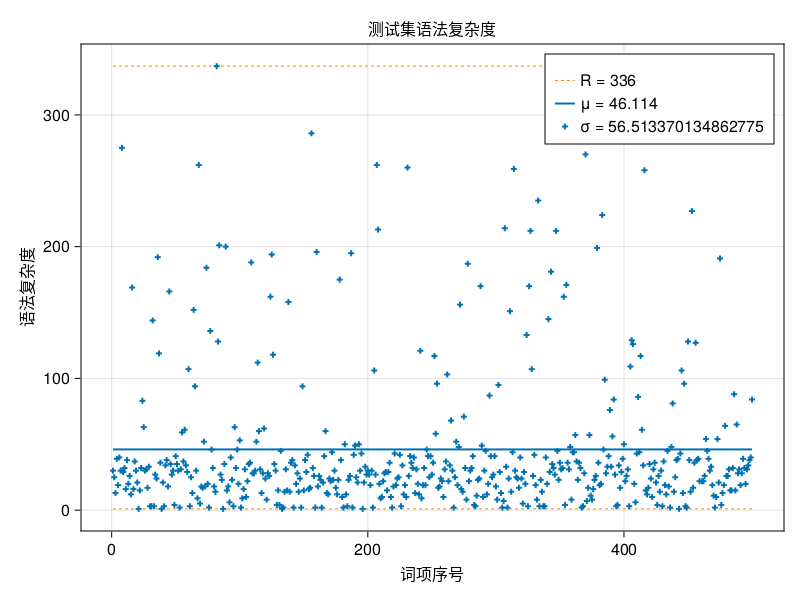

In [81]:
# 测试集情况
fig = Figure()
ax = Axis(fig[1, 1])

let 
    # 计算结果
    xs = 1:length(test_set.complexity)
    ys = test_set.complexity
    
    μ_y = sum(ys) / length(ys)
    σ_y = √(sum((ys .- μ_y) .^ 2) / length(ys)) # 【20230816 21:22:20】使用根号√计算方根
    max_y = max(ys...)
    min_y = min(ys...)
    one_ys = ones(length(ys))
    
    # 绘制最大、最小值
    l = lines!(
        ax, xs, max_y * one_ys; 
        label = "R = $(max_y-min_y)",
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = "0xff8800",
    )
    lines!(
        ax, xs, min_y * one_ys; 
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = l.color, # 复用颜色
    )
    # 绘制均值一条线
    lines!(
        ax, xs, μ_y * one_ys; 
        label = "μ = $μ_y",
        linewidth = 2,
        linestyle = nothing,
    )
    # 绘制散点图
    sl = scatterlines!(
        ax, xs, ys;
        label = "σ = $σ_y",
        linewidth = 0,
        markersize = 8,
        marker = :+,
    )
end

# 后期表格修饰
axislegend(""; position=:rt)
ax.title = "测试集语法复杂度"
ax.xlabel = "词项序号"
ax.ylabel = "语法复杂度"

current_figure()

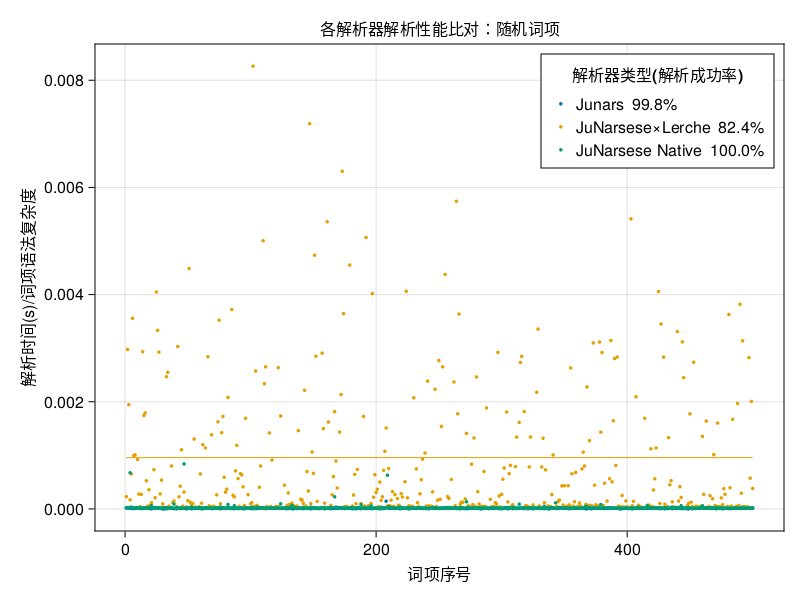

In [82]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    N = length(result.time)
    # 计算结果
    data = DataFrame(
        x = 1:N,
        y = result.time ./ result.complexity
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_y = sum(data.y) / length(data.y)
    mean_ys = mean_y * ones(length(data.y))
    lines!(
        ax, data.x, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项"
ax.xlabel = "词项序号"
ax.ylabel = "解析时间(s)/词项语法复杂度"

current_figure()

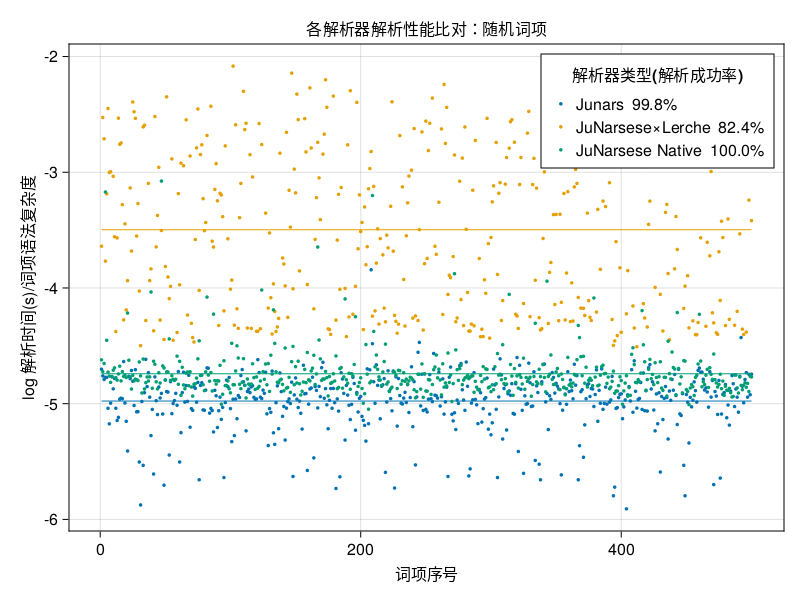

In [83]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    # 计算结果
    data = DataFrame(
        x = 1:length(result.time),
        y = log10.(result.time ./ result.complexity)
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    xs, ys = data.x, data.y
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_ys = sum(ys) / length(ys)
    mean_ys = mean_ys * ones(length(ys))
    lines!(
        ax, xs, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项"
ax.xlabel = "词项序号"
ax.ylabel = "log 解析时间(s)/词项语法复杂度"

current_figure()